# Proyek Klasifikasi Gambar: [200 Bird Species with 11,788 Images]
- **Nama:** [AHMAD ZAKY HUMAMI]
- **Email:** [mc009d5y0493@student.devacademy.id]
- **ID Dicoding:** [MC009D5Y0493]

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.applications.densenet import DenseNet121 # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau # type: ignore


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [4]:
# Pindahkan file kaggle.json ke direktori yang dikenali Kaggle CLI
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Download dataset dari Kaggle dan simpan 
!kaggle datasets download -d stealthknight/bird-vs-drone

# Ekstrak zip ke folder 'Dataset' langsung
zip_path = "bird-vs-drone.zip"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall()

# Hapus file zip setelah ekstraksi (optional)
os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/stealthknight/bird-vs-drone
License(s): MIT


### Data Preprocessing

#### Split Dataset

In [ ]:
# Pisahkan gambar ke folder class berdasarkan nama file
def organize_images_by_class():
      category_map = {
            'train': {'BTR': 'bird', 'DTR': 'drone'},
            'test':  {'BT': 'bird', 'DT': 'drone'},
            'valid': {'BV': 'bird', 'DV': 'drone'}
      }

      for split, prefix_map in category_map.items():
            img_folder = os.path.join('Dataset', split, 'images')
            for prefix, label in prefix_map.items():
                  label_dir = os.path.join('Dataset', split, label)
                  os.makedirs(label_dir, exist_ok=True)
                  for filename in os.listdir(img_folder):
                        if filename.startswith(prefix):
                              src = os.path.join(img_folder, filename)
                              dst = os.path.join(label_dir, filename)
                              shutil.move(src, dst)

            # Remove original "images" folder after moving
            try:
                  os.rmdir(img_folder)
            except OSError:
                  pass

organize_images_by_class()



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Dataset\\train\\images'

In [ ]:
#hapus folder labels
for split in ['train', 'test', 'valid']:
      label_path = os.path.join('Dataset', split, 'labels')
      if os.path.exists(label_path):
            shutil.rmtree(label_path)

In [ ]:
# Cek struktur dan resolusi dataset
def print_images_resolution(directory):
      total_images = 0
      for class_dir in os.listdir(directory):
            class_path = os.path.join(directory, class_dir)
            if not os.path.isdir(class_path):
                  continue
            image_files = os.listdir(class_path)
            num_images = len(image_files)
            print(f"{class_dir}: {num_images}")
            total_images += num_images
      print(f"Total: {total_images}")

print("Train Dataset:")
print_images_resolution("Dataset/train")
print("\nValid Dataset:")
print_images_resolution("Dataset/valid")
print("\nTest Dataset:")
print_images_resolution("Dataset/test")

Train Dataset:
bird: 7389
drone: 10934
Total: 18323

Valid Dataset:
bird: 701
drone: 1039
Total: 1740

Test Dataset:
bird: 361
drone: 528
Total: 889


In [ ]:
# Setup direktori path
base_dir = 'Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Target size dan batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.1,
      height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode='binary',
      shuffle=True
)

val_generator = val_datagen.flow_from_directory(
      val_dir,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode='binary',
      shuffle=False
)

test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode='binary',
      shuffle=False
)


Found 18323 images belonging to 2 classes.
Found 1740 images belonging to 2 classes.
Found 889 images belonging to 2 classes.


## Modelling

In [ ]:
model = Sequential([
      # Layer Konvolusi 1
      Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
      MaxPooling2D(pool_size=(2, 2)),

      # Layer Konvolusi 2
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),

      # Layer Konvolusi 3
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),

      # Flatten dan Fully Connected Layer
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')  # Binary classification
])

# Kompilasi model
model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
)

# Ringkasan model
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback: EarlyStopping dan ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
      'best_model.h5',
      monitor='val_accuracy',
      save_best_only=True,
      mode='max',
      verbose=1
)

# Train model
history = model.fit(
      train_generator,
      epochs=30,
      validation_data=val_generator,
      callbacks=[early_stop, checkpoint]
)


Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8318 - loss: 0.3769
Epoch 1: val_accuracy improved from -inf to 0.40230, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 339s 589ms/step - accuracy: 0.8319 - loss: 0.3766 - val_accuracy: 0.4023 - val_loss: 2.6461
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9800 - loss: 0.0625
Epoch 2: val_accuracy improved from 0.40230 to 0.40287, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 358s 625ms/step - accuracy: 0.9800 - loss: 0.0625 - val_accuracy: 0.4029 - val_loss: 3.4808
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9838 - loss: 0.0431
Epoch 3: val_accuracy improved from 0.40287 to 0.41954, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 350s 610ms/step - accuracy: 0.9838 - loss: 0.0431 - val_accuracy: 0.4195 - val_loss: 3.6966
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9880 - loss: 0.0331
Epoch 4: val_accuracy improved from 0.41954 to 0.47414, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 347s 606ms/step - accuracy: 0.9880 - loss: 0.0331 - val_accuracy: 0.4741 - val_loss: 3.3683
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9925 - loss: 0.0248
Epoch 5: val_accuracy improved from 0.47414 to 0.49828, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 358s 624ms/step - accuracy: 0.9925 - loss: 0.0248 - val_accuracy: 0.4983 - val_loss: 2.8978
Epoch 6/30
319/573 ━━━━━━━━━━━━━━━━━━━━ 2:31 595ms/step - accuracy: 0.9936 - loss: 0.0192

KeyboardInterrupt: 

## Evaluasi dan Visualisasi

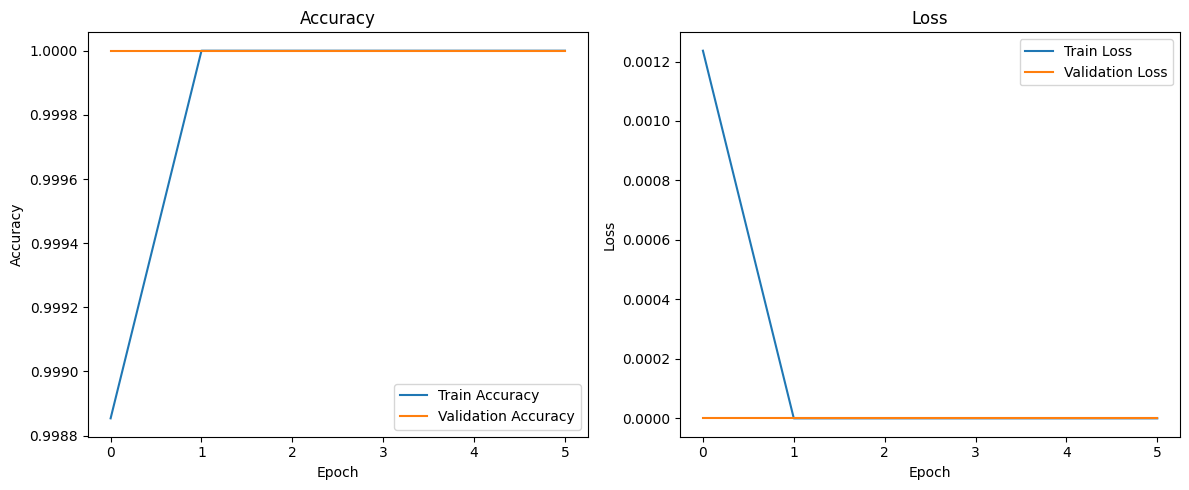

In [ ]:
# Visualisasi Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Visualisasi Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Konversi Model

## Inference (Optional)